In [20]:
## Upload all data from Module 6 data folder:

# all_gene_positions.txt
# all_incorrect_ORFS.csv
# all_promoter_sequences.csv
# full_sequence.fasta
# genome1.fasta
# genome1_gene_positions.txt
# genome2.fasta
# promoterPSSM_scores.txt
# rev_comp.fasta

# Reading Data




<font color='blue'>Cell 1
Importing libraries

In [21]:
import numpy as np
import pandas as pd

<font color='blue'>Cell 2
Reading data

In [22]:
all_gene_data = pd.read_csv('all_gene_positions.txt',header=None).to_numpy()
gene_position = all_gene_data[0:2269,:]
gene_position_r = all_gene_data[2269:,:]

#Reading full forward direction genome
with open('full_sequence.fasta', 'r') as file:
    full_seq = file.read().replace('\n', '')

#Remove first line (description of the data)
full_seq = full_seq[71:]

#Reading full reverse complement direction genome
with open('rev_comp.fasta', 'r') as file:
    full_rev = file.read().replace('\n', '')

#Remove the first line
full_rev = full_rev[82:]

<font color='blue'>Cell 3
Data set splitting

In [23]:
#The "sample" function will sort the data rows (proteins) randomly
def split_dataset_test_train(data,train_size):
  data = data.sample(frac=1).reset_index(drop=True)
  training_data = data.iloc[:int(train_size * len(data))].reset_index(drop=True)
  testing_data = data.iloc[int(train_size * len(data)):].reset_index(drop=True)
  return training_data, testing_data




# ORF finder

<font color='blue'>Cell 4
Finding codon positions

In [24]:
def codons(seq,start_c):
  stops = ["TAA","TGA","TAG"]
  #starts = ["ATG","GTG","TTG"]
  lst1 = [] #List for the stars codons
  lst2 = [] #List for the stop codons
  start = 0 #The start position of the sequence.
  #counter = 0 #Counter for 3 optional orfs.
  #initializes the lists for 3 optional orfs.
  for i in range (3):
      lst1.append([])
      lst2.append([])
  #Add to the lists the positions of the start and stop codons.
  while (start < 3): #(seq and start < 3)

      for i in range(start,len(seq),3):
          codon = seq[i:i+3] #The codon is 3 nucleotides.
          #print codon+ "\t"
          if (codon == start_c): #If the codon is  a start codon.
              lst1[start].append(i+1) #The position of the start codon.

          if (codon in stops): #if the codon is a stop codon.
              lst2[start].append(i+1) #The position of the stop codon.


      start += 1 #promotes the starting position.
      #counter += 1 #promotes the counter
  #print (lst1)
  #print ("------------------")
  #print (lst2)
  return lst1,lst2


<font color='blue'>Cell 5
Determining valid ORFs

In [25]:

def ORF(lst1,lst2):
  ORFstarts = []
  ORFstops = []
  found_frame = []
  curr_frame = 0
  min_len = 40 #OG 50
  start_min = 0
  look_back = 5
  max_fr_len = max([len(i) for i in lst1])
  all_frames = lst1[0] + lst1[1] + lst1[2]
  all_frames.sort()


  for s_cod in all_frames:
    if s_cod > start_min:
      for s_frame in range(len(lst1)):  #Find frame of start codon
        if s_cod in lst1[s_frame]:
          #frame = lst1[s_frame].index(s_cod)
          frame = s_frame
          found_frame.append(frame)
          break
      stop_count = 0
      for stp_cod in lst2[frame]:
        if stp_cod > s_cod + min_len:
          ORFstarts.append(s_cod)
          ORFstops.append(stp_cod)
          #start_min = stp_cod - look_back

          stop_count +=1
        if stop_count > 3:
          start_min = start_min + min_len - look_back
          #start_min += 1
          break



  return ORFstarts, ORFstops, found_frame

<font color='blue'>Cell 6
ORF checking function

In [26]:
#ORF finder part 3: Determining which found ORFs are correct and incorrect

def ORFcheck(ORFstr,ORFstp,gene_pos,rev):
  corr = 0
  corORF = np.empty((0,2))
  incorORF = np.empty((0,2))
  wrong_flag = 1

  for i in range(len(ORFstr)):
    wrong_flag = 1
    if rev:
      OC = np.array([ORFstr[i]-1, ORFstp[i]+2])
    else:
      OC = np.array([ORFstr[i], ORFstp[i]+2])
    if len(np.where(gene_pos==OC)[0]) == 2:

      if np.where(gene_pos==OC)[0][0] == np.where(gene_pos==OC)[0][1]:
        corr += 1
        OC = OC.reshape(1,-1)
        corORF = np.concatenate((corORF,OC), axis=0)
        wrong_flag = 0
    if wrong_flag == 1:
      OC = OC.reshape(1,-1)
      incorORF = np.concatenate((incorORF,OC), axis=0)
  return corr, corORF, incorORF

<font color='blue'>Cell 7
Running the previous functions with start codons from a list

In [27]:
def ORFfinder(dta,nucleotides, sel_gen, rev):
  all_corORFs = np.empty((0,2))
  all_incorORFs = np.empty((0,2))
  start_codons = ["ATG","GTG","TTG"]
  for start_cod in range(len(start_codons)):
    lst1, lst2 = codons(dta[0:nucleotides], start_codons[start_cod])
    ORFstarts, ORFstops, found_frame = ORF(lst1,lst2)
    corr, corORF, incorORF = ORFcheck(ORFstarts,ORFstops, sel_gen, rev)
    all_corORFs = np.concatenate((all_corORFs,corORF),axis=0)
    all_incorORFs = np.concatenate((all_incorORFs,incorORF),axis=0)


  return all_corORFs, all_incorORFs

<font color='blue'>Cell 8
Full incorrect ORF predictions are read from file

In [28]:
all_incorr_ORFs = pd.read_csv('all_incorrect_ORFs.csv')
incorORF = all_incorr_ORFs.iloc[:,0:2].to_numpy()
incorORF_r = all_incorr_ORFs.iloc[:,2:]
incorORF_r = incorORF_r.dropna().to_numpy()
incorORF = incorORF.astype(int)
incorORF_r = incorORF_r.astype(int)

# Codon Usage Frequency

<font color='blue'>Cell 9
Grouping genome into codons

In [29]:
#Grouping forward data into codons and hexs
framed = np.array([full_seq[i:i+3] for i in range(len(full_seq))])
framed = framed.reshape(-1,1)
framed_r = np.array([full_rev[i:i+3] for i in range(len(full_rev))])
framed_r = framed_r.reshape(-1,1)

<font color='blue'>Cell 10
Grouping coding sequences into codons

In [30]:
#Extracting coding sequences in framed codons and framed hexs
framed_cod_extract = np.array([framed[gene_position[i,0]-1:gene_position[i,1]-2:3] for i in range(len(gene_position))],dtype=object)
framed_cod_extract_r = np.array([framed_r[gene_position_r[i,0]:gene_position_r[i,1]-2:3] for i in range(len(gene_position_r))],dtype=object)


<font color='blue'>Cell 11
Grouping non coding sequences into codons

In [31]:
forward_N_cod = np.array([framed[incorORF[i,0]-1:incorORF[i,1]-2:3] for i in range(len(incorORF))],dtype=object)
reverse_N_cod = np.array([framed_r[incorORF_r[i,0]:incorORF_r[i,1]-2:3] for i in range(len(incorORF_r))],dtype=object)

<font color='blue'>Cell 12
Gathering all framed coding and non coding sequences

In [32]:
all_non_coding = np.concatenate((forward_N_cod,reverse_N_cod),axis=0)
all_coding = np.concatenate((framed_cod_extract[:-1],framed_cod_extract_r),axis=0)


<font color='blue'>Cell 13
Function for codon usage frequency features

In [33]:

def freq_vect(framed):
  H_0 = np.log(12)
  fvec = np.empty((0,12))
  Hs = []
  for i in range(len(framed)):
    framed_c_x = framed[i]
    flen = len(framed_c_x)*3
    p0 = [framed_c_x[i][0][0] for i in range(len(framed_c_x))]
    p1 = [framed_c_x[i][0][1] for i in range(len(framed_c_x))]
    p2 = [framed_c_x[i][0][2] for i in range(len(framed_c_x))]

    A = [p0.count('A'),p1.count('A'),p2.count('A')]
    C = [p0.count('C'),p1.count('C'),p2.count('C')]
    G = [p0.count('G'),p1.count('G'),p2.count('G')]
    T = [p0.count('T'),p1.count('T'),p2.count('T')]

    v = np.array((A,C,G,T))

    fv = np.array([base[pos]/flen for base in v for pos in range(3)])
    H = -1*sum(fv*np.log(fv))

    gamma = 1-(H/H_0)

    Hs.append(H)
    fv[0] = gamma
    fv = fv.reshape(1,-1)

    fvec = np.concatenate((fvec,fv), axis=0)
  return fvec

<font color='blue'>Cell 14
Running codon usage function on coding and non coding framed sequences

In [34]:
#Feature extraction with frequency analysis
coding_f_x = freq_vect(all_coding)
ncoding_f_x = freq_vect(all_non_coding)
#Replacing nans with 0s
coding_f_x[np.isnan(coding_f_x)] = 0
ncoding_f_x[np.isnan(ncoding_f_x)] = 0

print(coding_f_x[0])

<ipython-input-33-3840aaefb5a0>:20: RuntimeWarning: divide by zero encountered in log
  H = -1*sum(fv*np.log(fv))
<ipython-input-33-3840aaefb5a0>:20: RuntimeWarning: invalid value encountered in multiply
  H = -1*sum(fv*np.log(fv))


[0.01446451 0.09460008 0.05196914 0.07429963 0.0771417  0.09825416
 0.12992286 0.05724726 0.09378806 0.05115713 0.1043443  0.08932197]


# Hexamer Scoring

<font color='blue'>Cell 15
Grouping genome into hexamers, and grouping coding and non coding sequences into hexamers

In [35]:
hexed = np.array([full_seq[i:i+6] for i in range(len(full_seq))])
hexed = hexed.reshape(-1,1)

hexed_r = np.array([full_rev[i:i+6] for i in range(len(full_rev))])
hexed_r = hexed_r.reshape(-1,1)
hexed_r = hexed_r[:(len(hexed_r)-5)]

hexed_cod_extract = np.array([hexed[gene_position[i,0]-1:gene_position[i,1]-5] for i in range(len(gene_position))],dtype=object)
hexed_cod_extract_r = np.array([hexed_r[gene_position_r[i,0]:gene_position_r[i,1]-5] for i in range(len(gene_position_r))],dtype=object)

all_coding_hexs = np.concatenate((hexed_cod_extract,hexed_cod_extract_r),axis = 0,dtype=object)

hexed_ncod_extract = np.array([hexed[incorORF[i,0]-1:incorORF[i,1]-5] for i in range(len(incorORF))],dtype=object)
hexed_ncod_extract_r = np.array([hexed_r[incorORF_r[i,0]:incorORF_r[i,1]-5] for i in range(len(incorORF_r))],dtype=object)

all_ncoding_hexs = np.concatenate((hexed_ncod_extract,hexed_ncod_extract_r),axis = 0)

<font color='blue'>Cell 16
Grouping promoter and terminator regions for coding DNA into hexamers

In [36]:
#Getting hexed data for coding sequences
#NOTE: must remove the last gene from forward direction because a promoter-terminator pair doesn't exist (terminator out of range)
for_pro_hex = np.array([hexed[gene_position[i,0]-31:gene_position[i,0]-1] for i in range(len(gene_position)-1)])
for_ter_hex = np.array([hexed[gene_position[i,1]-5:gene_position[i,1]+25] for i in range(len(gene_position)-1)])
rev_pro_hex = np.array([hexed_r[gene_position_r[i,0]-30:gene_position_r[i,0]] for i in range(len(gene_position_r))])
rev_ter_hex = np.array([hexed_r[gene_position_r[i,1]-5:gene_position_r[i,1]+25] for i in range(len(gene_position_r))])

all_cod_pro = np.concatenate((for_pro_hex,rev_pro_hex),axis=0)
all_cod_ter = np.concatenate((for_ter_hex,rev_ter_hex),axis=0)

<font color='blue'>Cell 17
Grouping promoter and terminator regions for non coding DNA into hexamers

In [37]:
for_pro_n_hex = np.array([hexed[incorORF[i,0]-31:incorORF[i,0]-1] for i in range(len(incorORF))])
for_ter_n_hex = np.array([hexed[incorORF[i,1]-5:incorORF[i,1]+25] for i in range(len(incorORF))])
rev_pro_n_hex = np.array([hexed_r[incorORF_r[i,0]-30:incorORF_r[i,0]] for i in range(len(incorORF_r))])
rev_ter_n_hex = np.array([hexed_r[incorORF_r[i,1]-5:incorORF_r[i,1]+25] for i in range(len(incorORF_r))])

all_ncod_pro = np.concatenate((for_pro_n_hex,rev_pro_n_hex),axis=0)
all_ncod_ter = np.concatenate((for_ter_n_hex,rev_ter_n_hex),axis=0)

<font color='blue'>Cell 18
Function to count occurences of hexamers in a given set of sequences

In [38]:
#Finding occurrences of all hexamers in DNA sequences
def hex_count(hxd_data):
  all_individual_hexs = []
  for gene in range(len(hxd_data)):
    for hex in range(len(hxd_data[gene])):
      all_individual_hexs.append(hxd_data[gene][hex][0])
  hxs, hxs_count = np.unique(all_individual_hexs, return_counts=True)
  return hxs, hxs_count

<font color='blue'>Cell 19
Running the hex_count() function

In [39]:
#Finding occurences of hexes in coding promoters and terminators
coding_pro_hexs, coding_pro_hex_count = hex_count(all_cod_pro)
coding_ter_hexs, coding_ter_hex_count = hex_count(all_cod_ter)

#Finding occurences of hexes in non coding promoters and terminators
ncoding_pro_hexs, ncoding_pro_hex_count = hex_count(all_ncod_pro)
ncoding_ter_hexs, ncoding_ter_hex_count = hex_count(all_ncod_ter)

#Finding occurrences of all hexamers in non coding DNA
ncoding_hexs, ncoding_hex_count = hex_count(all_ncoding_hexs)
coding_hexs, coding_hex_count = hex_count(all_coding_hexs)

<font color='blue'>Cell 20
Finding the scores of hexamers for ORF usage

In [40]:
#Finding frequency of hexamer occurence in both coding/non coding regions
import math
hexs_not_in_coding = [hx for hx in ncoding_hexs if hx not in coding_hexs]

total_coding_hexs = sum(coding_hex_count)
total_ncoding_hexs = sum(ncoding_hex_count)
coding_hex_freqs = np.array([hex_count/total_coding_hexs for hex_count in coding_hex_count])
ncoding_hex_freqs = np.array([hex_count/total_ncoding_hexs for hex_count in ncoding_hex_count])

coding_hex_freqs = dict(zip(coding_hexs,coding_hex_freqs))
ncoding_hex_freqs = dict(zip(ncoding_hexs,ncoding_hex_freqs))


for hx in hexs_not_in_coding:
  coding_hex_freqs[hx] = 0


cod_ncod_rats = np.array([coding_hex_freqs[hx]/ncoding_hex_freqs[hx] for hx in ncoding_hexs])
cod_ncod_rats = np.log(cod_ncod_rats)
cod_ncod_rats[np.where(cod_ncod_rats == -math.inf)[0]] = -5
cod_ncod_rats = dict(zip(ncoding_hexs,cod_ncod_rats))

<font color='blue'>Cell 21

In [41]:
#Performing Hex analysis of sequences
#Getting rid of data for which there are no promoters/terminators
all_coding_hexs = np.delete(all_coding_hexs,len(gene_position)-1,axis=0)

<font color='blue'>Cell 22
Function to create hexamer scores for the promoter and terminator regions

In [42]:
def affix_scorer(cod_hx,cod_hx_cnt,ncod_hx,ncod_hx_cnt):
  import math
  hexs_not_in_coding = [hx for hx in ncod_hx if hx not in cod_hx]

  tot_cod_hexs = sum(cod_hx_cnt)
  tot_ncod_hexs = sum(ncod_hx_cnt)
  cod_hx_freqs = cod_hx_cnt/tot_cod_hexs
  ncod_hx_freqs = ncod_hx_cnt/tot_ncod_hexs

  cod_hx_freqs = dict(zip(cod_hx,cod_hx_freqs))
  ncod_hx_freqs = dict(zip(ncod_hx,ncod_hx_freqs))

  for hx in hexs_not_in_coding:
    cod_hx_freqs[hx] = 0

  ratio = np.array([cod_hx_freqs[hx]/ncod_hx_freqs[hx] for hx in ncod_hx])
  ratio = np.log(ratio)
  ratio[np.where(ratio == -math.inf)[0]] = -3
  freq_dict = dict(zip(ncod_hx,ratio))

  return freq_dict

#Performing Hex analysis of promoter/terminator regions
#1: Get frequency dictionaries for promoter/terminators
pro_freq_dict = affix_scorer(coding_pro_hexs, coding_pro_hex_count,ncoding_pro_hexs, ncoding_pro_hex_count)
ter_freq_dict = affix_scorer(coding_ter_hexs, coding_ter_hex_count,ncoding_ter_hexs, ncoding_ter_hex_count)

<ipython-input-42-00d22ad1bf28>:17: RuntimeWarning: divide by zero encountered in log
  ratio = np.log(ratio)


<font color='blue'>Cell 23
Function to sum the hexamer scores for each region

In [43]:
def seq_hex_score(hxd_data,freq_dict):
  score = []
  for gene in range(len(hxd_data)):
    curr_score = 0
    for hex in range(len(hxd_data[gene])):
        if len(hxd_data[gene][hex][0]) == 6:
            curr_score += freq_dict[hxd_data[gene][hex][0]]
        else :
            print(hxd_data[gene][hex][0])
    score.append(curr_score)
  return score

<font color='blue'>Cell 24
Running the scoring function on coding and non coding promoter/terminator regions

In [44]:
cod_hex_score = seq_hex_score(all_coding_hexs,cod_ncod_rats)
ncod_hex_score = seq_hex_score(all_ncoding_hexs,cod_ncod_rats)

#2: Use frequency dictionaries to get scores for all pro/term sequences
cod_pro_score = seq_hex_score(all_cod_pro,pro_freq_dict)
cod_ter_score =  seq_hex_score(all_cod_ter,ter_freq_dict)
ncod_pro_score = seq_hex_score(all_ncod_pro,pro_freq_dict)
ncod_ter_score = seq_hex_score(all_ncod_ter,ter_freq_dict)

# Defining Input Data

<font color='blue'>Cell 25
Grouping features for coding and non coding sequences

In [45]:
cod_data = np.concatenate((coding_f_x,np.array(cod_hex_score).reshape(-1,1),np.array(cod_pro_score).reshape(-1,1),np.array(cod_ter_score).reshape(-1,1)),axis=1)
ncod_data = np.concatenate((ncoding_f_x,np.array(ncod_hex_score).reshape(-1,1),np.array(ncod_pro_score).reshape(-1,1),np.array(ncod_ter_score).reshape(-1,1)),axis=1)

<font color='blue'>Cell 26
Selecting a subset of the non coding data and creating input X and output y data sets

In [46]:
#X = np.concatenate((coding_f_x,ncoding_f_x),axis=0)
R = np.random.RandomState(4)
ncod_size = R.randint(len(incorORF), size=4583)
ncod_data = ncod_data[ncod_size,:]

coding = np.array([0]*len(cod_data))
non_coding = np.array([1]*len(ncod_data))

X = np.concatenate((cod_data,ncod_data),axis=0)
y = np.concatenate((coding,non_coding),axis=0)

<font color='blue'>Cell 27
Normalizing the input data array X

In [47]:
from sklearn.preprocessing import StandardScaler

#Using sklearn to perform normalization
sc = StandardScaler()
#Performing the scaling on the training and test sets
X = sc.fit_transform(X)


<font color='blue'>Cell 28
Splitting into training and testing data

In [48]:
x_y = pd.DataFrame(np.concatenate((X,y.reshape(-1,1)), axis=1))
train_data, test_data = split_dataset_test_train(x_y,0.7)

X_train = train_data.iloc[:,:-1].to_numpy()
y_train = train_data.iloc[:,-1].to_numpy()

X_test = test_data.iloc[:,:-1].to_numpy()
y_test = test_data.iloc[:,-1].to_numpy()

# Creating and training the model

<font color='blue'>Cell 29
Defining activation functions

In [49]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))


<font color='blue'>Cell 30
Training function definition

In [50]:
def training(lr, batch_size, epochs):
  #Weight initialization
  w0 = 2*np.random.random((X_train.shape[1], 5)) - 1
  w1 = 2*np.random.random((5,)) - 1

  bh = np.random.randn(5)
  bo = np.random.randn(1)

  rem = len(X_train) % batch_size
  num_batch = len(X_train)//batch_size
  if rem != 0:
    num_batch += 1

  #Errors - for graph later
  errors = []

  for epoch in range(epochs):
  ############# feedforward
    for curr_batch in range(num_batch):
        # Phase 1
        batch_start = curr_batch * batch_size
        batch_end = batch_start + batch_size
        input_batch = X_train[batch_start:batch_end]

        zh = np.dot(input_batch, w0) + bh
        layer1 = sigmoid(zh)

        # Phase 2
        zo = np.dot(layer1, w1) + bo
        layer2 = sigmoid(zo)

    ########## Back Propagation

    ########## Phase 1
        labels_batch = y_train[batch_start:batch_end]
        layer2_error = layer2 - labels_batch

        layer2w_delta = np.dot(layer1.T, layer2_error.T)
        layer2b_delta = layer2_error.T

    ########## Phases 2

        dcost_dah = np.dot(layer2_error.reshape(-1,1) , w1.reshape(1,-1))
        dah_dzh = sigmoid_deriv(zh)

        layer1_error = dah_dzh * dcost_dah
        layer1w_delta = np.dot(input_batch.T, layer1_error)

        layer1b_delta = layer1_error

        # Update Weights ================

        w0 -= lr * layer1w_delta
        bh -= lr * layer1b_delta.sum(axis=0)

        w1 -= lr * layer2w_delta
        bo -= lr * layer2b_delta.sum(axis=0)

    error = np.mean(np.abs(layer2_error))
    errors.append(error)

  return [w0,bh,w1,bo], error, errors



<font color='blue'>Cell 31
Training the model

In [51]:
trained_params, error, errors = training(0.0001, 50,200)

<font color='blue'>Cell 32
Plotting the errors from training

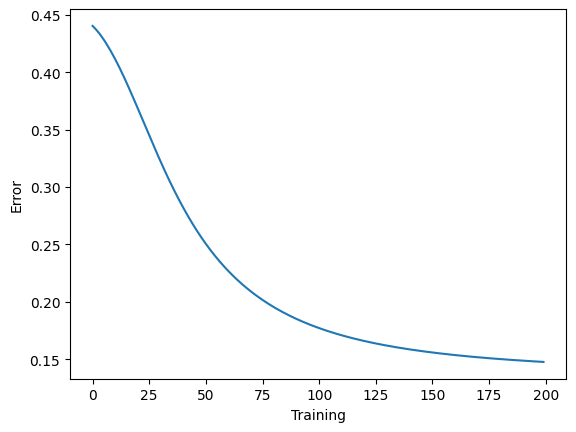

Training Accuracy 85.23%


In [52]:
import matplotlib.pyplot as plt

%matplotlib inline

#Plot the accuracy chart
accuracy = (1 - error) * 100

plt.plot(errors)
plt.xlabel('Training')
plt.ylabel('Error')
plt.show()

print("Training Accuracy " + str(round(accuracy,2)) + "%")

# Evaluating the Model

<font color='blue'>Cell 33
Evaluation function definition

In [53]:
def evaluation(params):
  w0 = params[0]
  bh = params[1]
  w1 = params[2]
  bo = params[3]

  zh = np.dot(X_test, w0) + bh
  layer1 = sigmoid(zh)

  # Phase 2 layer2 is final output
  zo = np.dot(layer1, w1) + bo
  layer2 = sigmoid(zo)

  return layer2

y_pred = evaluation(trained_params)

<font color='blue'>Cell 34
Creating the confusion matrix

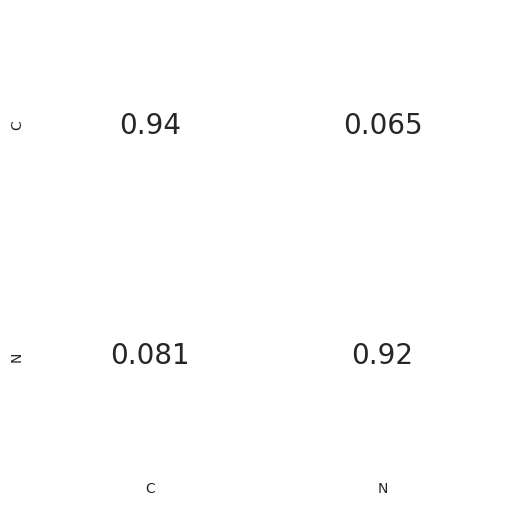

In [54]:
y_actual = pd.Series(y_test)
y_pred = pd.Series(y_pred.round())
cm = pd.crosstab(y_actual,y_pred).to_numpy()

cm_norm = np.array([cm[i][j]/cm[i].sum() for i in range(cm.shape[0]) for j in range(cm.shape[1])])
cm_norm = cm_norm.reshape(2,2)

import seaborn as sns
from matplotlib.colors import ListedColormap


#To use the seaborn heatmap, the confusion matrix array "cm" must be placed into a dataframe
df_cm = pd.DataFrame(cm_norm, index = [i for i in "CN"],
                  columns = [i for i in "CN"])


#Setting figure size
plt.figure(figsize = (6,6))

with sns.axes_style('white'):
    sns.heatmap(df_cm,
                cbar=False,
                square=False,
                annot=True,
                annot_kws={"size": 20},
                cmap=ListedColormap(['white']),
                linewidths=0.5)
    sns.set(font_scale=1.8)

# Adding PSSM Scoring

<font color='blue'>Cell 35
Reading data used for PSSM creation

In [55]:
all_promoter_seqs = pd.read_csv('all_promoter_sequences.csv')
for_seqs = all_promoter_seqs.iloc[:,0]
for_seqs = for_seqs.dropna().to_list()
rev_seqs = all_promoter_seqs.iloc[:,1].to_list()

<font color='blue'>Cell 36
Grouping sequences based on the distance between -35 and -10 box

In [56]:
for_15_seq = np.array([s for s in for_seqs if len(s) == 27])
rev_15_seq = np.array([s for s in rev_seqs if len(s) == 27])

for_16_seq = np.array([s for s in for_seqs if len(s) == 28])
rev_16_seq = np.array([s for s in rev_seqs if len(s) == 28])

for_17_seq = np.array([s for s in for_seqs if len(s) == 29])
rev_17_seq = np.array([s for s in rev_seqs if len(s) == 29])

for_18_seq = np.array([s for s in for_seqs if len(s) == 30])
rev_18_seq = np.array([s for s in rev_seqs if len(s) == 30])

for_19_seq = np.array([s for s in for_seqs if len(s) == 31])
rev_19_seq = np.array([s for s in rev_seqs if len(s) == 31])


all_15_seq = np.concatenate((for_15_seq,rev_15_seq), axis=0)
all_16_seq = np.concatenate((for_16_seq,rev_16_seq), axis=0)
all_17_seq = np.concatenate((for_17_seq,rev_17_seq), axis=0)
all_18_seq = np.concatenate((for_18_seq,rev_18_seq), axis=0)
all_19_seq = np.concatenate((for_19_seq,rev_19_seq), axis=0)


<font color='blue'>Cell 37
Finding the frequency nucleotide usage which will be used in PSSM creation

In [57]:
#Find freq of base occurence
freqA = full_seq.count('A')/len(full_seq)
freqC = full_seq.count('C')/len(full_seq)
freqG = full_seq.count('G')/len(full_seq)
freqT = full_seq.count('T')/len(full_seq)

<font color='blue'>Cell 38
Function that will extract -35 and -10 box regions from promoter sequences

In [58]:
#Removes the inter-box region
def boxExtract(seq):
  bextr = [s[0:6] + s[len(s)-6:len(s)] for s in seq]
  return bextr

<font color='blue'>Cell 39
Main function that will create the PSSMs

In [59]:
import math

def pssm(seq):

  n = len(seq)
  length = len(seq[0])

  A = np.zeros((1,length))[0]
  C = np.zeros((1,length))[0]
  G = np.zeros((1,length))[0]
  T = np.zeros((1,length))[0]

  for s in seq:
    Apos = [i for i, ltr in enumerate(s) if ltr == 'A']
    Cpos = [i for i, ltr in enumerate(s) if ltr == 'C']
    Gpos = [i for i, ltr in enumerate(s) if ltr == 'G']
    Tpos = [i for i, ltr in enumerate(s) if ltr == 'T']

    A[Apos] += 1
    C[Cpos] += 1
    G[Gpos] += 1
    T[Tpos] += 1

  pseudoA = np.array([(A[i] + (np.sqrt(n)*freqA)) / (n + np.sqrt(n)) for i in range(length)])
  pseudoC = np.array([(C[i] + (np.sqrt(n)*freqC)) / (n + np.sqrt(n)) for i in range(length)])
  pseudoG = np.array([(G[i] + (np.sqrt(n)*freqG)) / (n + np.sqrt(n)) for i in range(length)])
  pseudoT = np.array([(T[i] + (np.sqrt(n)*freqT)) / (n + np.sqrt(n)) for i in range(length)])

  A = -1*np.log10(pseudoA)
  C = -1*np.log10(pseudoC)
  G = -1*np.log10(pseudoG)
  T = -1*np.log10(pseudoT)

  sm = dict()
  sm['A'] = A
  sm['C'] = C
  sm['G'] = G
  sm['T'] = T

  return sm



<font color='blue'>Cell 40
Function that creates scores for all hexamers based on homology to AGGAGG (Shine Dalgarno)

In [60]:
#Function that finds all possible hexamers
hexed_data = [full_seq[i:i+6] for i in range(len(full_seq)-5)]
unique_hexs = np.unique(hexed_data)

#Function that scores all hexamers according to similarity to AGGAGG

consA = [i for i,j in enumerate('AGGAGG') if j == 'A']
consG = [i for i,j in enumerate('AGGAGG') if j == 'G']

def SD_dict():
  cons_scores = []
  for hx in unique_hexs:
    cons_score = 0
    G_occ = [i for i,j in enumerate(hx) if j == 'G']
    A_occ = [i for i,j in enumerate(hx) if j == 'A']
    for idx in G_occ:
      if idx in consG:
        cons_score += 1
    for idx in A_occ:
      if idx in consA:
        cons_score += 1

    cons_scores.append(cons_score)
  cons_scores = np.array(cons_scores)
  cons_scores = dict(zip(unique_hexs,cons_scores))
  return cons_scores

SDhex_score = SD_dict()

<font color='blue'>Cell 41
Running PSSM functions, and obtaining five PSSMs for different promoter box distances

In [61]:
extr15 = boxExtract(all_15_seq)
extr16 = boxExtract(all_16_seq)
extr17 = boxExtract(all_17_seq)
extr18 = boxExtract(all_18_seq)
extr19 = boxExtract(all_19_seq)


sm15 = pssm(extr15)
sm16 = pssm(extr16)
sm17 = pssm(extr17)
sm18 = pssm(extr18)
sm19 = pssm(extr19)

<font color='blue'>Cell 42
PSSM scoring function which will use the PSSMs

In [62]:
def scoring(seq,sm):
  all_scores = []

  box_extracted = True
  if box_extracted:
    seq = boxExtract(seq)

  for s in seq:
    Apos = [i for i, ltr in enumerate(s) if ltr == 'A']
    Cpos = [i for i, ltr in enumerate(s) if ltr == 'C']
    Gpos = [i for i, ltr in enumerate(s) if ltr == 'G']
    Tpos = [i for i, ltr in enumerate(s) if ltr == 'T']

    score = sum(sm['A'][Apos])+sum(sm['C'][Cpos])+sum(sm['G'][Gpos])+sum(sm['T'][Tpos])
    all_scores.append(score)

  return all_scores

<font color='blue'>Cell 43
Finding the true promoter regions that will be scored with PSSMs

In [63]:
#Extracting raw sequence promoters (not framed or hexed)
fpros = np.array([full_seq[gene_position[i,0]-252:gene_position[i,0]-1] for i in range(len(gene_position))])
rpros = np.array([full_rev[gene_position_r[i,0]-251:gene_position_r[i,0]] for i in range(len(gene_position_r))])

fpros = fpros[:-1]
all_pros = np.concatenate((fpros,rpros), axis = 0)

<font color='blue'>Cell 44
Finding the false promoter regions (from ORF finder predictions) that will be scored with PSSMs

In [64]:
def get_incorrect_promoters():
  fpros_n = np.array([full_seq[incorORF[i,0]-252:incorORF[i,0]-1] for i in range(len(incorORF))])
  rpros_n = np.array([full_rev[incorORF_r[i,0]-251:incorORF_r[i,0]] for i in range(len(incorORF_r))])

  all_pros_n = np.concatenate((fpros_n,rpros_n), axis = 0)
  return all_pros_n

all_pros_n = get_incorrect_promoters()

<font color='blue'>Cell 45
Function that will run the scoring function and return the minimum score for each PSSM and the locations of the minimum scores

In [65]:
def find_boxs(seq):

  pro_15 = [seq[i:i+27] for i in range(len(seq) - 27)]
  pro_16 = [seq[i:i+28] for i in range(len(seq) - 28)]
  pro_17 = [seq[i:i+29] for i in range(len(seq) - 29)]
  pro_18 = [seq[i:i+30] for i in range(len(seq) - 30)]
  pro_19 = [seq[i:i+31] for i in range(len(seq) - 31)]

  scr15 = scoring(pro_15, sm15)
  scr16 = scoring(pro_16, sm16)
  scr17 = scoring(pro_17, sm17)
  scr18 = scoring(pro_18, sm18)
  scr19 = scoring(pro_19, sm19)

  minscr15 = np.argmin(scr15)
  minscr16 = np.argmin(scr16)
  minscr17 = np.argmin(scr17)
  minscr18 = np.argmin(scr18)
  minscr19 = np.argmin(scr19)

  mins = dict()
  mins['b15'] = [seq[minscr15:minscr15+27], scr15[minscr15]]
  mins['b16'] = [seq[minscr16:minscr16+28], scr16[minscr16]]
  mins['b17'] = [seq[minscr17:minscr17+29], scr17[minscr17]]
  mins['b18'] = [seq[minscr18:minscr18+30], scr18[minscr18]]
  mins['b19'] = [seq[minscr19:minscr19+31], scr19[minscr19]]


  minscrs = [scr15[minscr15],scr16[minscr16],scr17[minscr17],scr18[minscr18],scr19[minscr19],minscr15,minscr16,minscr17,minscr18,minscr19]
  return minscrs



<font color='blue'>Cell 46
SD scoring function

In [66]:
#returns a list of SD scores in a given region of a promoter
def SDscorer(seq,reg_start,reg_stop):
  all_scrs = []
  for s in seq:
    region = s[250-reg_start:250-reg_stop+1]
    hxs = [region[i:i+6] for i in range(len(region)-5)]
    scrs = [SDhex_score[hx] for hx in hxs]
    all_scrs.append(scrs)
  return all_scrs

<font color='blue'>Cell 47


In [67]:
#Run all promoters extracted from genome through PSSMs
def all_true_test(sq):
  scores = []
  for pro in sq:
    scores.append(find_boxs(pro))
  return scores


<font color='blue'>Cell 48
Selecting a subset of the false promoters

In [68]:
all_pros_n = all_pros_n[ncod_size]

<font color='blue'>Cell 49
The PSSM scores for promoters are read from file to save execution time

In [69]:
promoterPSSM_scores = pd.read_csv('promoterPSSM_scores.txt',header=None).to_numpy()
true_promoter_PSSM = promoterPSSM_scores[:,0:10]
false_promoter_PSSM = promoterPSSM_scores[:,10:]

<font color='blue'>Cell 50
Running SD scoring function on true and false promoters

In [70]:
'''Change SD start and end'''
SD_region_start = 14
SD_region_end = 3

promoter_SD_scores = SDscorer(all_pros,SD_region_start,SD_region_end)
false_SD_scores = SDscorer(all_pros_n,SD_region_start,SD_region_end)

<font color='blue'>Cell 51
Grouping

In [71]:
#X data only with SD scores
true_X_SD = np.array(promoter_SD_scores)
false_X_SD = np.array(false_SD_scores)

#X data only with Prib scores
true_X_Prib = np.array(true_promoter_PSSM)
false_X_Prib = np.array(false_promoter_PSSM)

#X data with both feature sets
true_X = np.concatenate((promoter_SD_scores,true_promoter_PSSM),axis=1)
false_X = np.concatenate((false_SD_scores,false_promoter_PSSM),axis=1)


<font color='blue'>Cell 52
Concatenating feature groups

In [72]:
cod_data_SD = np.concatenate((cod_data,true_X_SD),axis=1)
ncod_data_SD = np.concatenate((ncod_data,false_X_SD),axis=1)

cod_data_Prib = np.concatenate((cod_data,true_X_Prib),axis=1)
ncod_data_Prib = np.concatenate((ncod_data,false_X_Prib),axis=1)

cod_data_all = np.concatenate((cod_data,true_X),axis=1)
ncod_data_all = np.concatenate((ncod_data,false_X),axis=1)

X_SD = np.concatenate((cod_data_SD,ncod_data_SD),axis=0)
X_Prib = np.concatenate((cod_data_Prib,ncod_data_Prib),axis=0)
all_features = np.concatenate((cod_data_all,ncod_data_all),axis=0)



# Final Feature Selection

<font color='blue'>Cell 53
Importing libraries

In [73]:
def final_feature_selection(sel_feats,inp_dat):
  feature_list = dict()
  feature_list[0] = [0,1,2,3,4,5,6,7,8,9,10,11]
  feature_list[1] = [12,13,14]
  feature_list[2] = [15,16,17,18,19,20,21]
  feature_list[3] = [22,23,24,25,26,27,28,29,30,31]

  #sel_feats = [True,False,False,True]

  features = [i for i, x in enumerate(sel_feats) if x]
  final_features = []
  features = [final_features + feature_list[i] for i in features]
  flat_list = []
  for sublist in features:
      for item in sublist:
          flat_list.append(item)

  out_dat = inp_dat[:,flat_list]
  return out_dat




# Exercise 6.2

<font color='blue'>Cell 54
Selecting features to be used by boolean true/false

In [74]:
'''Select/Deselect features by changing True/False assignments'''
                    #Codon Usage  #Hexamer Scores   #SD       #PSSMs
selected_features = [True,        True,             True,     True]
X = final_feature_selection(selected_features,all_features)

<font color='blue'>Cell 55
Normalizing data

In [75]:
sc = StandardScaler()
X = sc.fit_transform(X)

<font color='blue'>Cell 56
Creating the corresponding outputs, ie. 0 = true (coding), 1 = false (non coding)

In [76]:
#Making the output values (coding or non coding seqs)
coding = np.array([0]*len(true_X))
non_coding = np.array([1]*len(false_X))
y = np.concatenate((coding,non_coding),axis=0)

<font color='blue'>Cell 57
Train test set splitting

In [77]:
x_y = pd.DataFrame(np.concatenate((X,y.reshape(-1,1)), axis=1))
train_data, test_data = split_dataset_test_train(x_y,0.7)

X_train = train_data.iloc[:,:-1].to_numpy()
y_train = train_data.iloc[:,-1].to_numpy()

X_test = test_data.iloc[:,:-1].to_numpy()
y_test = test_data.iloc[:,-1].to_numpy()

<font color='blue'>Cell 58
Setting parameters and training the model

In [78]:
#Training the model

learning_rate = 0.0001
batch_size = 50
epochs = 100

trained_params, error, errors = training(learning_rate, batch_size, epochs)

<font color='blue'>Cell 59
Plotting errors from training

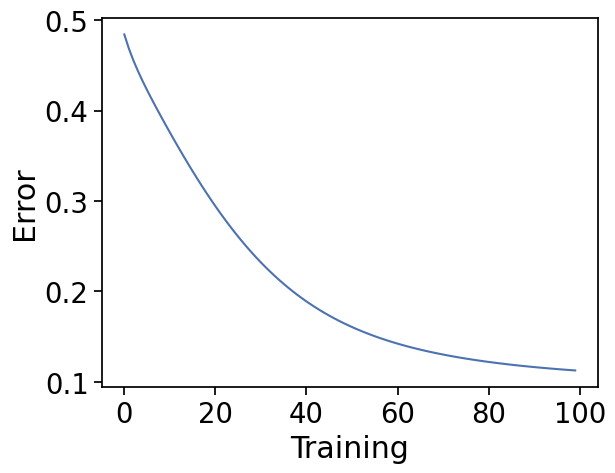

Training Accuracy 88.75%


In [79]:
import matplotlib.pyplot as plt

%matplotlib inline

#Plot the accuracy chart
accuracy = (1 - error) * 100

plt.plot(errors)
plt.xlabel('Training')
plt.ylabel('Error')
plt.show()

print("Training Accuracy " + str(round(accuracy,2)) + "%")

<font color='blue'>Cell 60
Evaluating the model on the test set

In [80]:
#Testing the model
y_pred = evaluation(trained_params)

<font color='blue'>Cell 61
Creating the confusion matrix

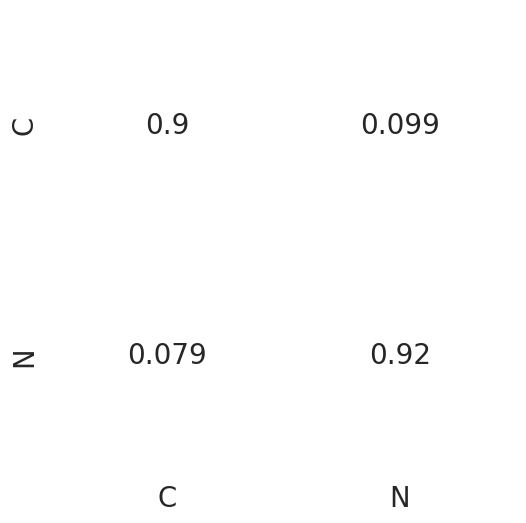

In [81]:
y_actual = pd.Series(y_test)
y_pred = pd.Series(y_pred.round())
cm = pd.crosstab(y_actual,y_pred).to_numpy()

cm_norm = np.array([cm[i][j]/cm[i].sum() for i in range(cm.shape[0]) for j in range(cm.shape[1])])
cm_norm = cm_norm.reshape(2,2)

import seaborn as sns
from matplotlib.colors import ListedColormap


#To use the seaborn heatmap, the confusion matrix array "cm" must be placed into a dataframe
df_cm = pd.DataFrame(cm_norm, index = [i for i in "CN"],
                  columns = [i for i in "CN"])


#Setting figure size
plt.figure(figsize = (6,6))

with sns.axes_style('white'):
    sns.heatmap(df_cm,
                cbar=False,
                square=False,
                annot=True,
                annot_kws={"size": 20},
                cmap=ListedColormap(['white']),
                linewidths=0.5)
    sns.set(font_scale=1.8)